<font size=7> Latencies Analysis

# get pairs

In [1]:
import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, plot_latency_dist_hist, plot_latency_angle_hist, \
                                 plot_cross_sttc_pairs, plot_vector_layout2, plot_vector_layout4, read_autocurated_data
from human_hip.animate import animate_latencies

from scipy import stats
from ipywidgets import interact_manual, interact
import matplotlib.pyplot as plt
import numpy as np
from human_hip.spike_data import latencies


In [2]:
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, cross_sttc, plot_pair_analysis, plot_cross_sttc_pairs
import pickle
import matplotlib.pyplot as plt
from ipywidgets import interact_manual
import numpy as np
import pickle

In [3]:
sd = read_autocurated_data( "/workspaces/human_hippocampus/data/ephys/2023-12-03-e-Hc112823_avv9hckcr1/derived/kilosort2/Hc112823_avv9hckcr1_21841_120323_3_acqm.zip" )


In [4]:

import numpy as np
from human_hip.spike_data import latencies, cross_sttc


def curate_latencies(sd,  latency_ms=30, sttc_cutoff = 0, latency_cutoff=1, sttc_delta=20, pval=.05, min_latencies=25 ):

    # Get all latencies whose STTC is above some minimum STTC cuttoff
    print(sd.N**2 , "Starting Pairs")
    sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
    pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
    for i in range(sd.N):
        for j in range(i+1,sd.N):
            if sttc_neo[i,j] > sttc_cutoff:
                pairs.append([i,j])
    print( len(pairs), "pairs above sttc cutoff")

    # Get all latencies whose median latency is above some minimum Latency Cuttoff
    pairs_late = [] #lags_late = []
    for pair in pairs:
        pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=latency_ms)  #latency= np.median(pair_latencies)
        if len(pair_latencies)>=min_latencies and abs(np.mean(pair_latencies))> latency_cutoff :
            if np.mean(pair_latencies) < 0:
                pair_latencies = latencies( pair[1], pair[0], sd, ms_cutoff_high=latency_ms) 
                if np.mean(pair_latencies)> latency_cutoff and len(pair_latencies)>=min_latencies:
                    t_stat, p_value = stats.ttest_1samp( pair_latencies, 0)
                    if p_value < pval:
                        pairs_late.append( [ pair[1], pair[0] ] )
            else:
                t_stat, p_value = stats.ttest_1samp( pair_latencies, 0)
                if p_value < pval:
                    pairs_late.append( pair )
    print( len(pairs_late), "pairs above latencency cutoff")

    mean_latencies = []
    for pair in pairs_late:
        mean_latency = np.mean( latencies( pair[0], pair[1], sd, ms_cutoff_high=latency_ms)  )
        mean_latencies.append(mean_latency)
    print("all final pairs positive?:", np.all( np.array(mean_latencies)>0 ))
    #good_pairs =   np.array(pairs_final)

    return  pairs_late

In [5]:
# load good_pairs.pkl
latency_ms = 30
with open("hc112823_acid_good_pairs.pkl", "rb") as filename:
    good_pairs = pickle.load(filename)
good_pairs2 = np.array(good_pairs)

# latency_ms = 30
# good_pairs = curate_latencies(sd, latency_ms=30, sttc_cutoff = 0.01, latency_cutoff=1, sttc_delta=20, pval=.05, min_latencies=25 ) 
# good_pairs2 = np.array(good_pairs)
# with open("hc112823_acid_good_pairs.pkl", "wb") as filename:
#     pickle.dump(good_pairs, filename)


In [6]:
# # dump good_pairs into pickle file
# with open("hc112823_acid_good_pairs.pkl", "wb") as filename:
#     pickle.dump(good_pairs, filename)

In [7]:
print(len(good_pairs),"good pairs")
mean_latencies = []
for pair in good_pairs:
    mean_latency = np.mean( latencies( pair[0], pair[1], sd, ms_cutoff_high=latency_ms)  )
    mean_latencies.append(mean_latency)
print("all final pairs positive?:", np.all( np.array(mean_latencies)>0 ))

784 good pairs


all final pairs positive?: True


# Make plots

all final pairs positive?: True


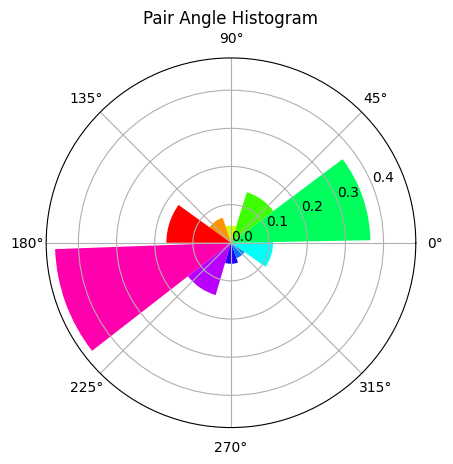

In [7]:
plot_latency_angle_hist(sd, good_pairs,  by_firing_rate=False, late_cutoff_high=latency_ms)

all final pairs positive?: True


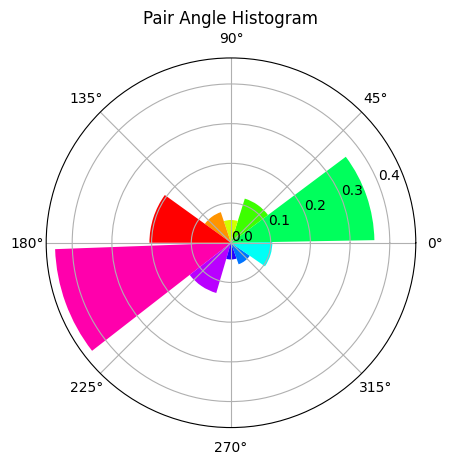

In [8]:
plot_latency_angle_hist(sd, good_pairs,  by_firing_rate=True, late_cutoff_high=latency_ms)

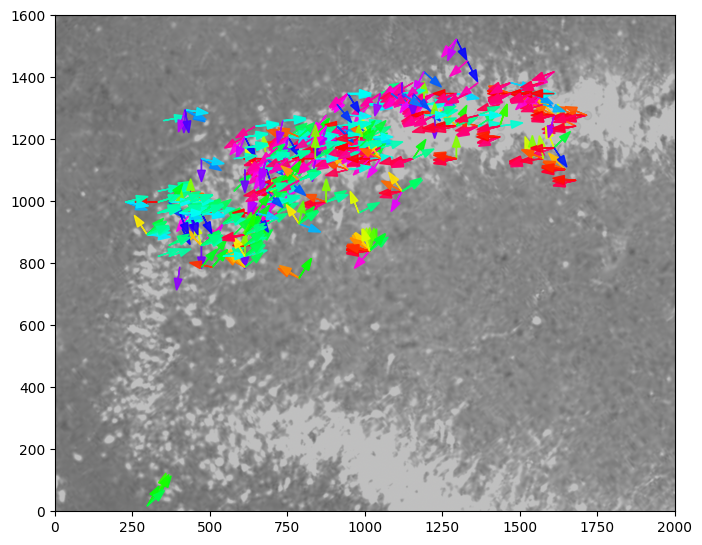

In [9]:
plot_vector_layout( sd, good_pairs2,  image_path="/workspaces/human_hippocampus/data/histology/hc112823_bw_old.png",
                     xlim=(0,2000), ylim=(0,1600) )

In [7]:
from ipywidgets import interact_manual, interact
from scipy import stats

def pairs_hisogram(good_pairs, sd, ms_cutoff_high=latency_ms ):
    @interact
    def plot_pair(pair_i = (0, len(good_pairs)-1) ):
        latencies_pair = latencies( good_pairs[pair_i][0], good_pairs[pair_i][1], sd, ms_cutoff_high=ms_cutoff_high )
        plt.xlim(-ms_cutoff_high, ms_cutoff_high)
        plt.hist(latencies_pair, bins=12)
        print("Pair: ", good_pairs[pair_i][0],good_pairs[pair_i][1] )
        print("Latency Mean:\t", np.mean(latencies_pair ) )

        t_stat, p_value = stats.ttest_1samp( latencies_pair, 0)
        one_sided_p_value = p_value / 2 if t_stat > 0 else 1 - p_value / 2
        print("T-Test 1-Side:\t", one_sided_p_value )  #print("T-Test: ", stats.ttest_1samp(latencies_pair, 0)[1] )
        
pairs_hisogram( good_pairs, sd, ms_cutoff_high=latency_ms)

interactive(children=(IntSlider(value=293, description='pair_i', max=587), Output()), _dom_classes=('widget-in…

# Curate Arrows


Pairs removed by SD cutoff: 0


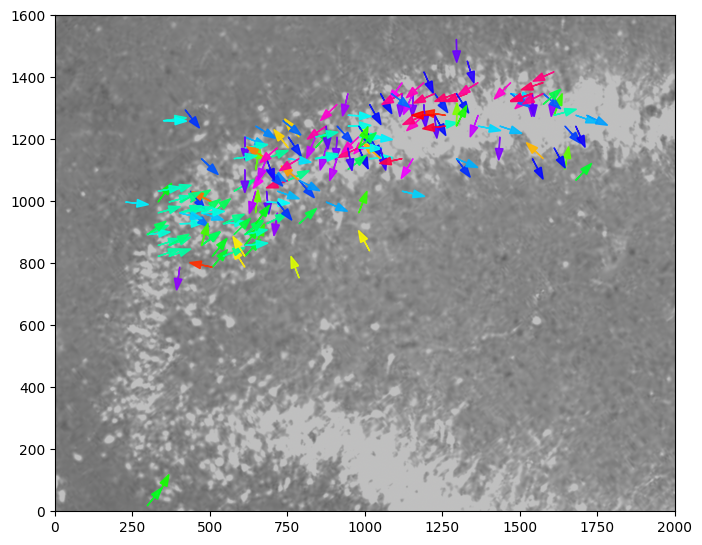

In [8]:
plot_vector_layout4( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc112823_bw_old.png", figsize=(8, 8),
                     xlim=(0,2000), ylim=(0,1600), sd_cuttoff=100 , latency_ms=30)

Pairs removed by SD cutoff: 85


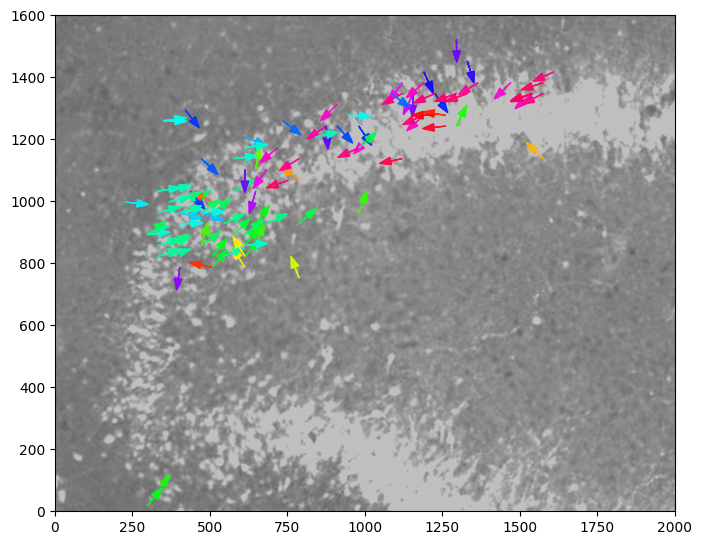

In [9]:
plot_vector_layout4( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc112823_bw_old.png", figsize=(8, 8),
                     xlim=(0,2000), ylim=(0,1600), sd_cuttoff=1 , latency_ms=30)

# <font color="brown"> Get SD with angles numbers rotated module 2 pi

helper functions

In [82]:
import math
import numpy as np

def rotate_angles( angles, add=1):
    adjusted_angles = []
    for num in angles:
        num += add         # Add 1 to the number
        adjusted_num = ((num + math.pi) % (2 * math.pi)) - math.pi  # modulo operation to wrap within -pi to pi
        adjusted_angles.append(adjusted_num)
    return adjusted_angles


In [83]:
def rotated_sd( angles ):
    sds = []
    for i in range(-3,1): #[-3,1]
        sds.append( np.std( rotate_angles(angles, add=i), ddof=1) )
    return min(sds)

# def rotated_sd( angles ):
#     sds = []
#     for i in range(-3,4):
#         sds.append( np.std( rotate_angles(angles, add=i), ddof=1) )
#     return min(sds)

In [84]:
def rotated_mean( angles ):
    sds = []
    means = []
    for i in range(-3,1): #[-3,1]
        new_angles = rotate_angles(angles, add=i)
        sds.append( np.std( new_angles, ddof=1) )
        new_mean = np.mean(new_angles) - i 
        adjusted_mean = ((new_mean + math.pi) % (2 * math.pi)) - math.pi
        means.append( adjusted_mean   ) 
    return means[np.argmin(sds)]

# def rotated_mean( angles ):
#     sds = []
#     means = []
#     for i in range(-3,4):
#         new_angles = rotate_angles(angles, add=i)
#         sds.append( np.std( new_angles, ddof=1) )
#         means.append( np.mean( new_angles) - i ) 
#     return means[np.argmin(sds)]

set parameters and import stuff

In [58]:
from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrow
from sklearn import preprocessing
import numpy as np
from human_hip.spike_data import latencies, latency_times, plot_raster, plot_footprint, cross_sttc
from braingeneers.analysis.analysis import SpikeData
import warnings
import diptest 
import math
import matplotlib.cm as cm
from ipywidgets import interact_manual
from matplotlib.ticker import MaxNLocator

In [59]:
pairs = good_pairs
image_path="/workspaces/human_hippocampus/data/histology/hc112823_bw_old.png"
figsize=(8, 8)
xlim=(0,2000)
ylim=(0,1600)
sd_cuttoff=1
latency_ms=30

create function `plot_vector_layout5`

In [85]:

def plot_vector_layout5( sd, pairs, image_path=None, figsize=(8, 8), xlim=None, ylim=None, 
                         sd_cuttoff=100 , latency_ms=30):

    # make sure all latencies have positive mean
    # pairs = pairs    # ?avoid bug? 
    # mean_latencies = []
    # for pair in pairs:
    #     mean_latency = np.mean( latencies( pair[0], pair[1], sd, ms_cutoff_high=latency_ms)  )
    #     mean_latencies.append(mean_latency)
    # print("all final pairs positive?:", np.all( np.array(mean_latencies)>0 ))

    # Get the x/y locations of the start and end neurons of each pair
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
    neuron_xy = np.array(neuron_xy)

    # Latencies count                  
    latency_counts = []
    for pair in pairs:
        latency_counts.append( len(latency_times( pair[0], pair[1], sd, ms_cutoff_high=latency_ms, positive_only=True )) )

    # Creat arrows show angle of information flow from a neuron
    starts = neuron_xy[ [pair[0] for pair in pairs] ]  # Get the x/y locations of the start and end neurons of each pair
    ends = neuron_xy[ [pair[1] for pair in pairs] ]
    centered = ends-starts   # Get the directions of arrows, then make of of them the same length
    normalized = preprocessing.normalize(centered) #* 75
    angles = np.arctan2( normalized[:, 1], normalized[:, 0] ) 

    # clump by starting pair angle counted by angle
    pair_dict = {}
    for i in range(len(pairs)):
        key, value = pairs[i]
        if key in pair_dict:
            pair_dict[key] = pair_dict[key] + [ angles[i] ] * latency_counts[i]
        else:
            pair_dict[key] = [ angles[i] ] * latency_counts[i]

    # create new dictionary of just mean angles
    pair_angles = {}
    pair_sd = {}
    for key, value in pair_dict.items():
        pair_angles[key] =  rotated_mean( value ) #sum(value) / len(value)
        pair_sd[key] = rotated_sd( value ) #/ len(value)

    # Plot original scatter
    plt.figure(figsize=(8, 8))
    ax = plt.axes()
    if image_path is not None:
        img = plt.imread(image_path)      # Load in image
        plt.imshow(img,  extent=[0, 3850, 0, 2100]) 
    plt.xlim( xlim )
    plt.ylim( ylim )    

    # Draw Arrows
    cmap = cm.get_cmap('hsv')
    pair_removed = 0
    for pair, angle in pair_angles.items():
        if pair_sd[pair] < sd_cuttoff :
            angle2 = (angle*-1+ np.pi)/np.pi/2
            start = neuron_xy[ pair ]  
            arrow = FancyArrow( 
                    start[0], start[1], np.cos(angle)*75 , np.sin(angle)*75, length_includes_head=True, head_width=25,
                    linewidth=1, color=cmap(angle2,alpha=0.9)  ) #color="red"
            plt.gca().add_patch(arrow)
        else:
            pair_removed = pair_removed + 1
    print("Pairs removed by SD cutoff:", pair_removed )

/tmp/ipykernel_55689/3886185629.py:14: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():
/tmp/ipykernel_55689/3886185629.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


Pairs removed by SD cutoff: 101


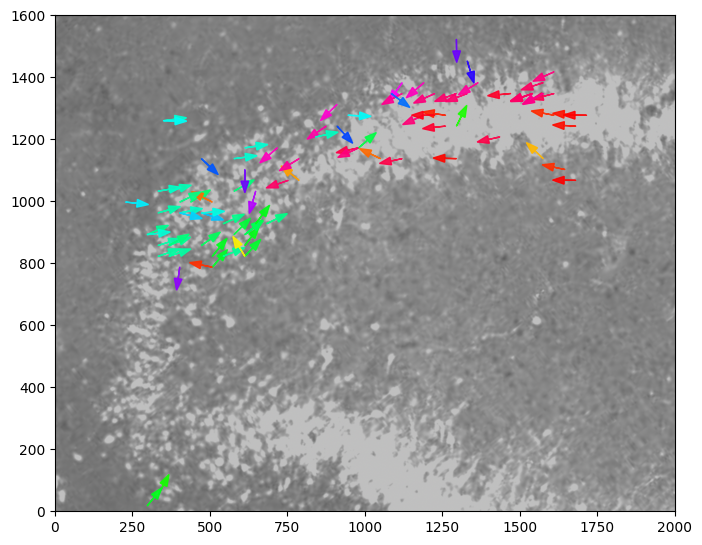

In [88]:
plot_vector_layout5( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc112823_bw_old.png",
                         figsize=(8, 8), xlim=(0,2000), ylim=(0,1600),
                         sd_cuttoff=.5 , latency_ms=30)

/tmp/ipykernel_55689/3886185629.py:14: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():
/tmp/ipykernel_55689/3886185629.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


Pairs removed by SD cutoff: 61


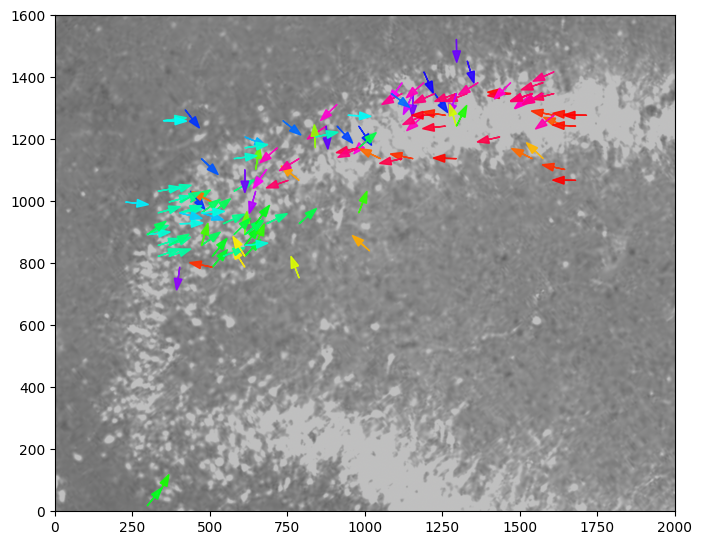

In [89]:
plot_vector_layout5( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc112823_bw_old.png",
                         figsize=(8, 8), xlim=(0,2000), ylim=(0,1600),
                         sd_cuttoff=1, latency_ms=30)

get dictionary of angles

In [67]:

    # Get the x/y locations of the start and end neurons of each pair
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
    neuron_xy = np.array(neuron_xy)

    # Latencies count                  
    latency_counts = []
    for pair in pairs:
        latency_counts.append( len(latency_times( pair[0], pair[1], sd, ms_cutoff_high=latency_ms, positive_only=True )) )

    # Creat arrows show angle of information flow from a neuron
    starts = neuron_xy[ [pair[0] for pair in pairs] ]  # Get the x/y locations of the start and end neurons of each pair
    ends = neuron_xy[ [pair[1] for pair in pairs] ]
    centered = ends-starts   # Get the directions of arrows, then make of of them the same length
    normalized = preprocessing.normalize(centered) #* 75
    angles = np.arctan2( normalized[:, 1], normalized[:, 0] ) 

    # clump by starting pair angle counted by angle
    pair_dict = {}
    for i in range(len(pairs)):
        key, value = pairs[i]
        if key in pair_dict:
            pair_dict[key] = pair_dict[key] + [ angles[i] ] * latency_counts[i]
        else:
            pair_dict[key] = [ angles[i] ] * latency_counts[i]
            
    # create new dictionary of just mean angles
    pair_angles = {}
    pair_sd = {}
    for key, value in pair_dict.items():
        pair_angles[key] =  rotated_mean( value ) #sum(value) / len(value)
        pair_sd[key] = rotated_sd( value ) #/ len(value)

/tmp/ipykernel_55689/1295400477.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


plot max and min angle to see what the modulo is for them

In [68]:
all_numbers = [num for sublist in pair_dict.values() for num in sublist]

# Step 2: Find the maximum and minimum values
print( max(all_numbers) , "max")
print( min(all_numbers) , "min")

3.141592653589793 max
-3.105245032570773 min


Check angles histograms <font color="orange">(looking at index 104, we see that he code works)

In [53]:
@interact(num=(0,len(pair_dict)))
def angles_hist(num):
    key = list(pair_dict.keys())[num]
    print("SD:", np.std( pair_dict[key], ddof=1 ))
    print( "Rotated SD:", rotated_sd( pair_dict[key] ) )

    plt.hist( pair_dict[key] )

interactive(children=(IntSlider(value=96, description='num', max=192), Output()), _dom_classes=('widget-intera…

get all rotated sds

In [77]:
    # create new dictionary of just mean angles
    pair_angles = {}
    pair_sd = {}
    for key, value in pair_dict.items():
        pair_angles[key] =  rotated_mean( value ) #sum(value) / len(value)
        pair_sd[key] = rotated_sd( value ) #/ len(value)

plot results

/tmp/ipykernel_55689/770522604.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


Pairs removed by SD cutoff: 62


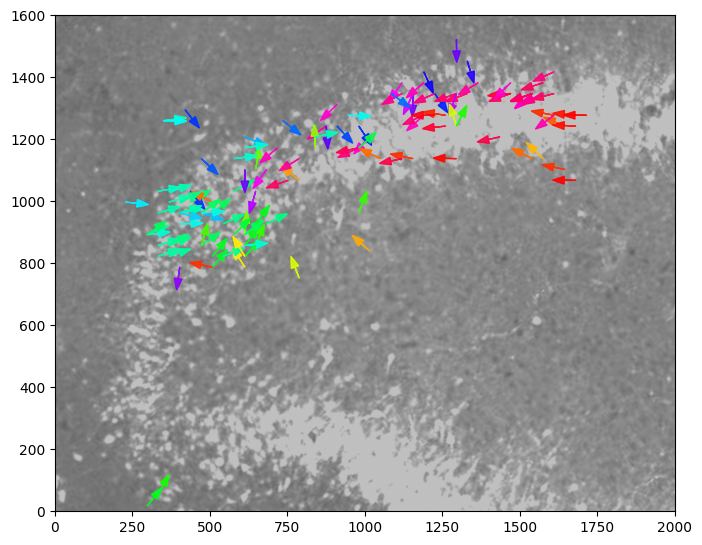

In [78]:
    # Plot original scatter
    plt.figure(figsize=(8, 8))
    ax = plt.axes()
    if image_path is not None:
        img = plt.imread(image_path)      # Load in image
        plt.imshow(img,  extent=[0, 3850, 0, 2100]) 
    plt.xlim( xlim )
    plt.ylim( ylim )    

    # Draw Arrows
    cmap = cm.get_cmap('hsv')
    pair_removed = 0
    for pair, angle in pair_angles.items():
        if pair_sd[pair] < sd_cuttoff :
            angle2 = (angle*-1+ np.pi)/np.pi/2
            start = neuron_xy[ pair ]  
            arrow = FancyArrow( 
                    start[0], start[1], np.cos(angle)*75 , np.sin(angle)*75, length_includes_head=True, head_width=25,
                    linewidth=1, color=cmap(angle2,alpha=0.9)  ) #color="red"
            plt.gca().add_patch(arrow)
        else:
            pair_removed = pair_removed + 1
    print("Pairs removed by SD cutoff:", pair_removed )

/tmp/ipykernel_55689/770522604.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


Pairs removed by SD cutoff: 61


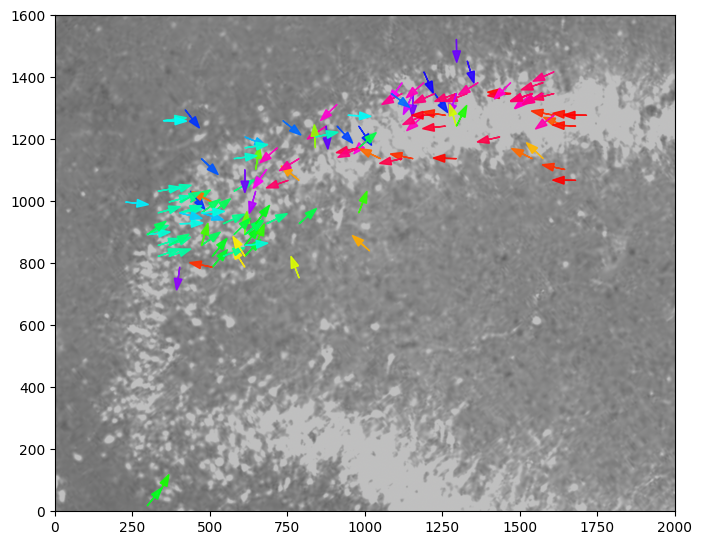

In [74]:
    # Plot original scatter
    plt.figure(figsize=(8, 8))
    ax = plt.axes()
    if image_path is not None:
        img = plt.imread(image_path)      # Load in image
        plt.imshow(img,  extent=[0, 3850, 0, 2100]) 
    plt.xlim( xlim )
    plt.ylim( ylim )    

    # Draw Arrows
    cmap = cm.get_cmap('hsv')
    pair_removed = 0
    for pair, angle in pair_angles.items():
        if pair_sd[pair] < sd_cuttoff :
            angle2 = (angle*-1+ np.pi)/np.pi/2
            start = neuron_xy[ pair ]  
            arrow = FancyArrow( 
                    start[0], start[1], np.cos(angle)*75 , np.sin(angle)*75, length_includes_head=True, head_width=25,
                    linewidth=1, color=cmap(angle2,alpha=0.9)  ) #color="red"
            plt.gca().add_patch(arrow)
        else:
            pair_removed = pair_removed + 1
    print("Pairs removed by SD cutoff:", pair_removed )